# Priority Classification of Baltimore 911 Service Requests.

#### Data Source : https://data.baltimorecity.gov/Public-Safety/911-Police-Calls-for-Service/xviu-ezkt
#### By : P Akash

In [1]:
# Checking versions of Libraries

# Python version
import sys
print("Python version : ", sys.version)

# Numpy
import numpy as np
print("Numpy version : ", np.__version__)

# Pandas
import pandas as pd
print("Pandas version : ", pd.__version__)

# Matplotlib
import matplotlib
print("Matplotlib version : ", matplotlib.__version__)

# Sklearn
import sklearn
print("Sklearn version : ", sklearn.__version__)

#Seaborn
import seaborn as sb
print("Seaborn version : ", sb.__version__)

Python version :  3.5.6 |Anaconda custom (64-bit)| (default, Aug 26 2018, 21:41:56) 
[GCC 7.3.0]
Numpy version :  1.15.2
Pandas version :  0.23.4
Matplotlib version :  3.0.0
Sklearn version :  0.20.0
Seaborn version :  0.9.0


In [2]:
# Importing Libraries
import time
from geopy.geocoders import Nominatim
import re
import datetime
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize

# classifiers

# K-Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier

# naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

# decision tree
from sklearn.tree import DecisionTreeClassifier

# ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
print("Successfully imported libraries".center(110,"."))

.......................................Successfully imported libraries........................................


In [3]:
# Importing the data 

# Original Dataset
print("Size of Original Dataset : ")
o_dataset = pd.read_csv("final_dataset.csv")
print(o_dataset.shape)

Size of Original Dataset : 
(1342995, 8)


In [4]:
o_dataset.head(1)

,recordId,callDateTime,priority,district,description,callNumber,incidentLocation,location
0,4107136,01/01/2019 12:01:00 AM,Non-Emergency,ND,Business Check,P190010003,5100 YORK RD,"5100 YORK RD\nBALTIMORE, MD\n(39.350595, -76.6..."


### Sampling 

In [5]:
# sampling of the original Dataset
#s_dataset = o_dataset.sample(n = 200000, replace = False, axis = 0)
#s_dataset.to_csv("sample_final_dataset.csv", index = False, encoding = "utf-8")

In [6]:
# Starting work on Sample Dataset
print("Size of Sample Dataset : ")
df = pd.read_csv("sample_final_dataset.csv", index_col = "recordId")
print(df.shape) # Shape of the dataset
# sample dataset contains 1 lakh rows and 8 columns

Size of Sample Dataset : 
(100000, 7)


In [7]:
df.columns.values

array(['callDateTime', 'priority', 'district', 'description',
       'callNumber', 'incidentLocation', 'location'], dtype=object)

In [8]:
df.dtypes

callDateTime        object
priority            object
district            object
description         object
callNumber          object
incidentLocation    object
location            object
dtype: object

In [9]:
df.head(1)

,callDateTime,priority,district,description,callNumber,incidentLocation,location
recordId,,,,,,,
3917199,10/23/2018 09:35:00 AM,Medium,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,..."


In [10]:
# Rearranging Columns
df = df[["callDateTime", "district", "description","callNumber","incidentLocation","location","priority"]]
df.head(1)

,callDateTime,district,description,callNumber,incidentLocation,location,priority
recordId,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium


In [11]:
# creating a copy of sample dataset to perform cleaning operations on it
dummy_df = df
dummy_df.head(2)

,callDateTime,district,description,callNumber,incidentLocation,location,priority
recordId,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High


### Feature Enginnering & Cleaning

In [12]:
# Extracting Features from 'callDateTime'

dummy_df["Date"] = dummy_df["callDateTime"].apply(lambda x: str(x).split(" ")[0].strip())
dummy_df["Time"] = dummy_df["callDateTime"].apply(lambda x: str(x).split(" ")[1].strip())
dummy_df["Time_type"] = dummy_df["callDateTime"].apply(lambda x : str(x).split(" ")[2].strip())
print(dummy_df.shape)
dummy_df.head(3)

(100000, 10)


,callDateTime,district,description,callNumber,incidentLocation,location,priority,Date,Time,Time_type
recordId,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium,10/23/2018,09:35:00,AM
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High,12/15/2018,09:16:00,AM
3812097,09/15/2018 10:37:00 PM,CD,Private Tow,P182582915,0 W NORTH AV,"0 W NORTH AV\nBALTIMORE, MD",Non-Emergency,09/15/2018,10:37:00,PM


In [13]:
# converting date to proper format
# Overwriting the Exisiting Date column into a proper format to extract features out of it

# date format should be "%Y-%M-%d"
def convert_date(row):
    if len(str(row.Date)) > 0:
        if str(row.Date).find("/") > 0:
            temp = str(row.Date).split("/")
            #return temp
            return(str(temp[2]) + "-" + str(temp[0]) + "-" + str(temp[1]))
        elif str(row.Date).find("-") > 0:
            temp = str(row.Date).split("-")
            return(str(temp[0]) + "-" + str(temp[1]) + "-" + str(temp[2]))
            #if len(str(temp[0]) == 4):
            #    return(str(temp[0]) + "-" + str(temp[1]) + "-" + str(temp[2]))
            #elif len(str(temp[0]) == 2):
            #    return(str(temp[2]) + "-" + str(temp[0]) + "-" + str(temp[1]))

dummy_df["Date"] = dummy_df.apply(convert_date, axis = "columns")
#date = dummy_df.apply(convert_date, axis = "columns")
dummy_df.head(2)

,callDateTime,district,description,callNumber,incidentLocation,location,priority,Date,Time,Time_type
recordId,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium,2018-10-23,09:35:00,AM
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High,2018-12-15,09:16:00,AM


In [14]:
# converting date into days

def date_to_day(row):
    if len(str(row.Date)) > 0:
        return datetime.datetime.strptime(row.Date,"%Y-%M-%d").strftime("%A")

dummy_df["Day"] = dummy_df.apply(date_to_day, axis = "columns")
print(dummy_df.shape)
dummy_df.head(2)

(100000, 11)


,callDateTime,district,description,callNumber,incidentLocation,location,priority,Date,Time,Time_type,Day
recordId,,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium,2018-10-23,09:35:00,AM,Tuesday
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High,2018-12-15,09:16:00,AM,Monday


In [15]:
# converting time to sessions

# converting time to 24 hour format
dummy_df['timestamp'] = pd.to_datetime(dummy_df.callDateTime, format='%m/%d/%Y %I:%M:%S %p')

#creating sessions out of 24 hour time format
dummy_df["session"] = pd.cut(dummy_df.timestamp.dt.hour,[0,6,12,18,24],labels=['Night','Morning','Afternoon','Evening'])

dummy_df["session"] = dummy_df["session"].fillna("Night")
dummy_df.head(2)

,callDateTime,district,description,callNumber,incidentLocation,location,priority,Date,Time,Time_type,Day,timestamp,session
recordId,,,,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium,2018-10-23,09:35:00,AM,Tuesday,2018-10-23 09:35:00,Morning
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High,2018-12-15,09:16:00,AM,Monday,2018-12-15 09:16:00,Morning


In [16]:
# Dropping Na values from the dataset
print("Shape of dataset Before removing NA values : ",dummy_df.shape)
dummy_df = dummy_df.dropna(subset = ["location"])
print("Shape of dataset After removing NA values : ",dummy_df.shape)

Shape of dataset Before removing NA values :  (100000, 13)
Shape of dataset After removing NA values :  (99850, 13)


In [17]:
# Extracting Features from location
# Extrcted latitude and longitude out of location by removing unnecessary string values

def extract_location(row):
    if len(str(row.location)) > 4:
        if row.location.partition("(")[-1][:-1] == "":
            return ("none,none")
        else:
            temp = row.location.partition("(")[-1][:-1]
            temp = temp.split(",")
            latitude = temp[0].strip()
            longitude = temp[1].strip()
            return (latitude + "," + longitude)
    else:
        return("none,none")
        
dummy_df["ext_location"] = dummy_df.apply(extract_location, axis = "columns")
dummy_df.head(2)

/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,callDateTime,district,description,callNumber,incidentLocation,location,priority,Date,Time,Time_type,Day,timestamp,session,ext_location
recordId,,,,,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium,2018-10-23,09:35:00,AM,Tuesday,2018-10-23 09:35:00,Morning,"39.292646,-76.677151"
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High,2018-12-15,09:16:00,AM,Monday,2018-12-15 09:16:00,Morning,"39.309471,-76.641835"


In [18]:
# Cleaning Values from dataset where latitude and longitude not found
print("Shape of Dataset before removing NONE values : ", dummy_df.shape)
dummy_df = dummy_df[dummy_df["ext_location"] != "none,none"]
print("Shape of Dataset after removing NONE values : ", dummy_df.shape)

Shape of Dataset before removing NONE values :  (99850, 14)
Shape of Dataset after removing NONE values :  (77489, 14)


In [19]:
# extracting latitude and longitude out of ext_location
dummy_df["latitude"] = dummy_df["ext_location"].apply(lambda x: str(x.split(",")[0]))
dummy_df["longitude"] = dummy_df["ext_location"].apply(lambda x: str(x.split(",")[1]))
print(dummy_df.shape)
dummy_df.head(2)

(77489, 16)


,callDateTime,district,description,callNumber,incidentLocation,location,priority,Date,Time,Time_type,Day,timestamp,session,ext_location,latitude,longitude
recordId,,,,,,,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium,2018-10-23,09:35:00,AM,Tuesday,2018-10-23 09:35:00,Morning,"39.292646,-76.677151",39.292646,-76.677151
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High,2018-12-15,09:16:00,AM,Monday,2018-12-15 09:16:00,Morning,"39.309471,-76.641835",39.309471,-76.641835


In [20]:
# removing columns where latitude and longitude not found

dummy_df = dummy_df[dummy_df["latitude"] != "FORMER LOCATION) BALTIMORE"]
dummy_df = dummy_df[dummy_df["latitude"] != "CURRENT LOCATION) BALTIMORE"]
dummy_df = dummy_df[dummy_df["latitude"] != "FORMER LOC BALTIMORE"]
dummy_df = dummy_df[dummy_df["latitude"] != "CURRENT LOCA BALTIMORE"]
dummy_df = dummy_df[dummy_df["latitude"] != "ON SKELETON BALTIMORE"]

dummy_df.shape

(77485, 16)

In [21]:
# converting latitude and longitude to numeric values

dummy_df.latitude = pd.to_numeric(dummy_df.latitude)
dummy_df.longitude = pd.to_numeric(dummy_df.longitude)
dummy_df.dtypes

callDateTime                object
district                    object
description                 object
callNumber                  object
incidentLocation            object
location                    object
priority                    object
Date                        object
Time                        object
Time_type                   object
Day                         object
timestamp           datetime64[ns]
session                   category
ext_location                object
latitude                   float64
longitude                  float64
dtype: object

In [22]:
# Cleaning Call Number

def clean_call(row):
    if bool(re.match("P",row.callNumber)):
        return row.callNumber[1:]
    else:
        return row.callNumber

dummy_df["call_number"] = dummy_df.apply(clean_call, axis = "columns")
print(dummy_df.shape)
dummy_df.head(2)

(77485, 17)


,callDateTime,district,description,callNumber,incidentLocation,location,priority,Date,Time,Time_type,Day,timestamp,session,ext_location,latitude,longitude,call_number
recordId,,,,,,,,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,SW,911/NO VOICE,P182960717,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...",Medium,2018-10-23,09:35:00,AM,Tuesday,2018-10-23 09:35:00,Morning,"39.292646,-76.677151",39.292646,-76.677151,182960717
4060328,12/15/2018 09:16:00 AM,WD,SILENT ALARM,P183490699,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...",High,2018-12-15,09:16:00,AM,Monday,2018-12-15 09:16:00,Morning,"39.309471,-76.641835",39.309471,-76.641835,183490699


In [23]:
dummy_df.columns.values.tolist()

['callDateTime',
 'district',
 'description',
 'callNumber',
 'incidentLocation',
 'location',
 'priority',
 'Date',
 'Time',
 'Time_type',
 'Day',
 'timestamp',
 'session',
 'ext_location',
 'latitude',
 'longitude',
 'call_number']

In [24]:
# Reordering the whole dataset columns
dummy_df = dummy_df[["callDateTime","Date","Day","timestamp","Time","Time_type","session","callNumber","call_number","district","description","incidentLocation","location","ext_location","latitude","longitude","priority"]]
dummy_df.columns.values.tolist()

['callDateTime',
 'Date',
 'Day',
 'timestamp',
 'Time',
 'Time_type',
 'session',
 'callNumber',
 'call_number',
 'district',
 'description',
 'incidentLocation',
 'location',
 'ext_location',
 'latitude',
 'longitude',
 'priority']

In [25]:
dummy_df.head(2)

,callDateTime,Date,Day,timestamp,Time,Time_type,session,callNumber,call_number,district,description,incidentLocation,location,ext_location,latitude,longitude,priority
recordId,,,,,,,,,,,,,,,,,
3917199,10/23/2018 09:35:00 AM,2018-10-23,Tuesday,2018-10-23 09:35:00,09:35:00,AM,Morning,P182960717,182960717,SW,911/NO VOICE,3600 W FRANKLIN ST,"3600 W FRANKLIN ST\nBALTIMORE, MD\n(39.292646,...","39.292646,-76.677151",39.292646,-76.677151,Medium
4060328,12/15/2018 09:16:00 AM,2018-12-15,Monday,2018-12-15 09:16:00,09:16:00,AM,Morning,P183490699,183490699,WD,SILENT ALARM,2400 PENNSYLVANIA AV,"2400 PENNSYLVANIA AV\nBALTIMORE, MD\n(39.30947...","39.309471,-76.641835",39.309471,-76.641835,High


In [26]:
# removing unnecessary columns and creating a new dataset for modelling 
new_df = dummy_df[['Date', 'Day', 'Time', 'Time_type', 'session', 'district', 'description', 'call_number', 'incidentLocation', 'latitude', 'longitude', 'priority']]
new_df.head(2)

,Date,Day,Time,Time_type,session,district,description,call_number,incidentLocation,latitude,longitude,priority
recordId,,,,,,,,,,,,
3917199,2018-10-23,Tuesday,09:35:00,AM,Morning,SW,911/NO VOICE,182960717,3600 W FRANKLIN ST,39.292646,-76.677151,Medium
4060328,2018-12-15,Monday,09:16:00,AM,Morning,WD,SILENT ALARM,183490699,2400 PENNSYLVANIA AV,39.309471,-76.641835,High


### Visualization 

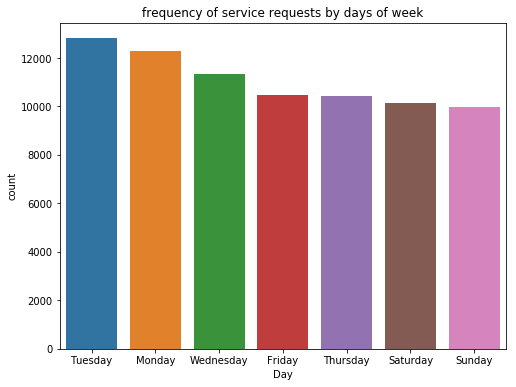

In [27]:
# plot to see the frequency of service requests at Baltimore police department according to days of the week.
plt.figure(figsize = (8,6))
ax = sb.countplot(new_df.Day, order = new_df.Day.value_counts().index)
plt.title("frequency of service requests by days of week")
ax.figure.savefig("week.png")

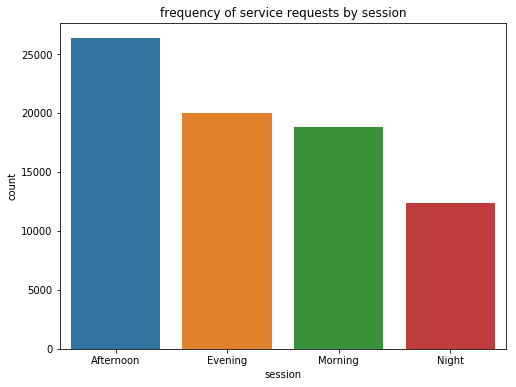

In [28]:
# plot to see the frequency of service requests at Baltimore police department according to session of the day.
plt.figure(figsize = (8,6))
ax = sb.countplot(new_df.session, order = new_df.session.value_counts().index)
plt.title("frequency of service requests by session")
ax.figure.savefig("session.png")

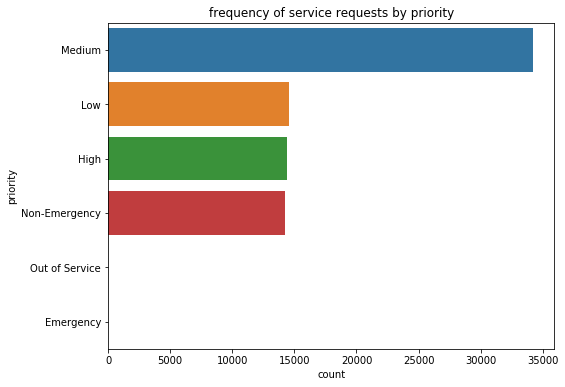

In [29]:
# plot to show the frequency of service requests at Baltimore police department according to the priority of request.
plt.figure(figsize = (8,6))
ax = sb.countplot(y = new_df.priority, order = new_df.priority.value_counts().index)
plt.title("frequency of service requests by priority")
ax.figure.savefig("priority.png")

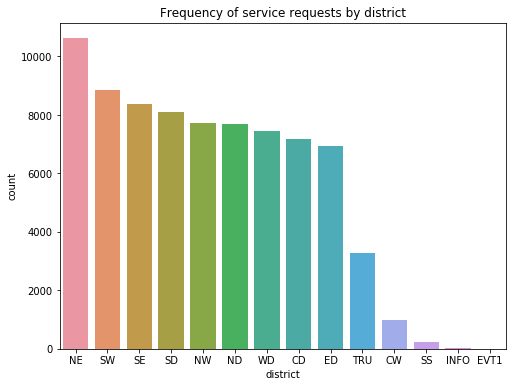

In [30]:
# plot to show the frequency of service requests from each district at Baltimore Police Department
plt.figure(figsize = (8,6))
ax = sb.countplot(new_df.district, order = new_df.district.value_counts().index)
plt.title("Frequency of service requests by district")
ax.figure.savefig("district.png")

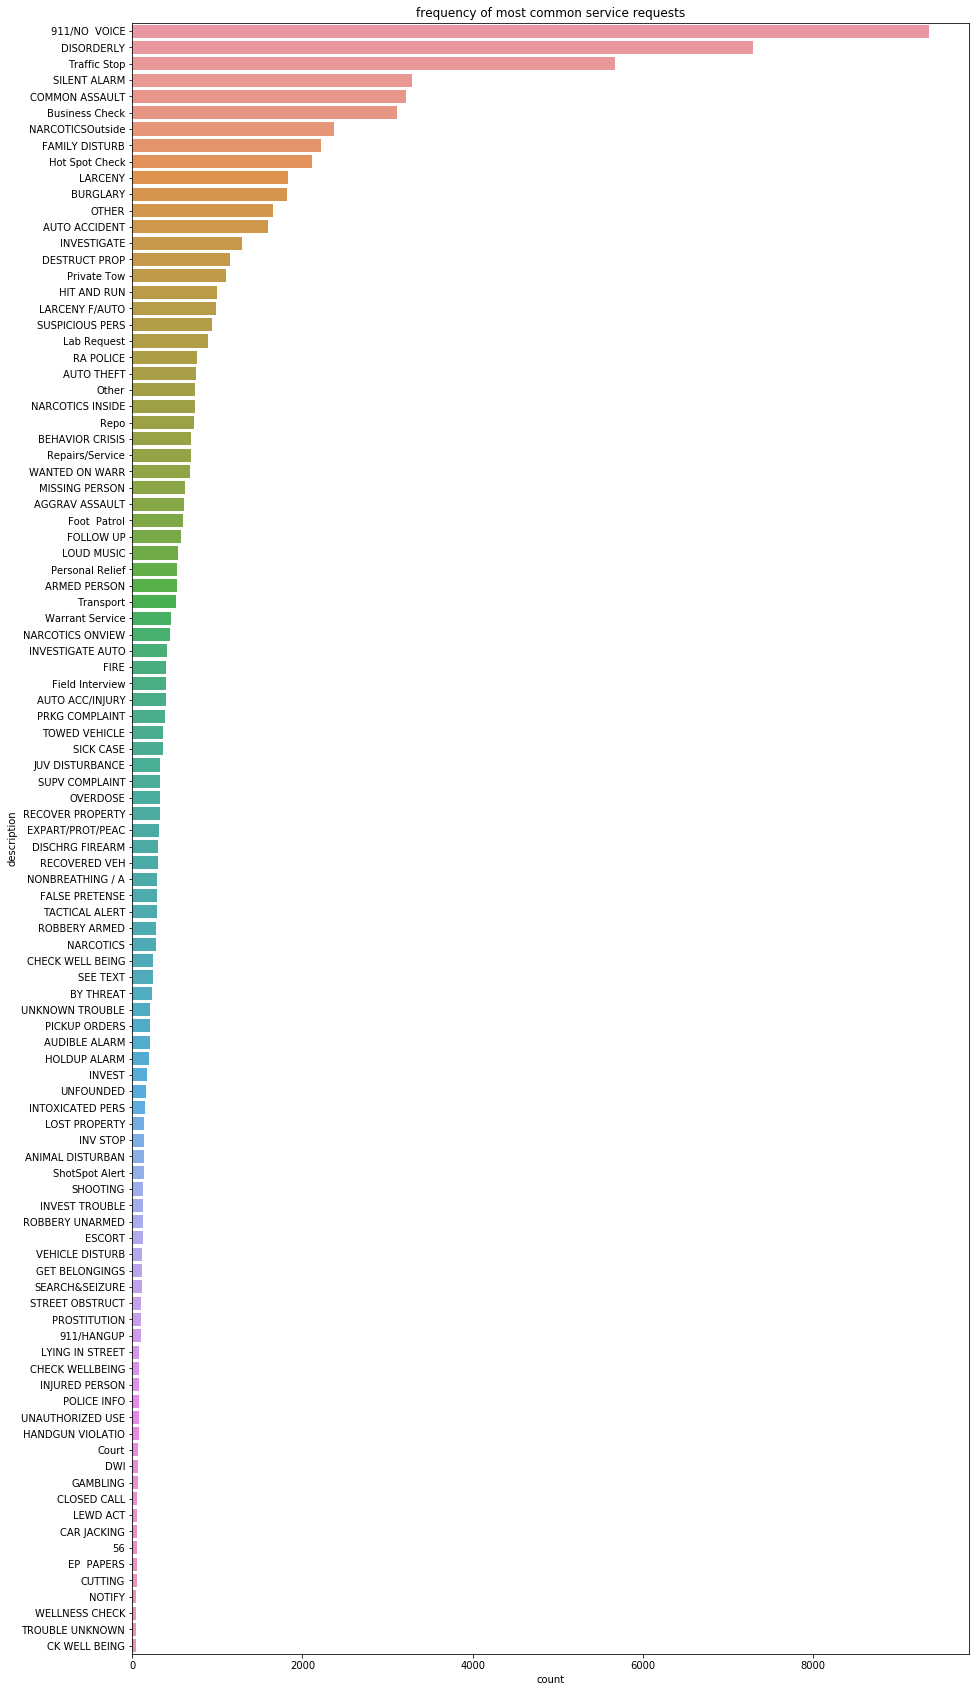

In [31]:
# plot to show the frequency of type of service reported at Baltimore Police Department
plt.figure(figsize = (15,30))
ax = sb.countplot(y = new_df.description, order = new_df.description.value_counts()[:100].index)
plt.title("frequency of most common service requests")
ax.figure.savefig("requests.png")

In [32]:
# Creating sub datasets to convert categorical values into indicator values

priority_df = new_df[["priority"]]
priority_df.priority.replace({"Emergency" : 1,"High" : 2, "Medium" : 3, "Low" : 4, "Non-Emergency" : 5, "Out of Service" : 6}, inplace = True)
print("Shape of Dataset".center(110,"-"))
print(priority_df.shape)
print("Description of Dataset".center(110,"-"))
print(priority_df.describe())
print("Unique values and their counts in the dataset".center(110,"-"))
print(priority_df.priority.value_counts())
priority_df.head(2)

-----------------------------------------------Shape of Dataset-----------------------------------------------
(77485, 1)
--------------------------------------------Description of Dataset--------------------------------------------
           priority
count  77485.000000
mean       3.370201
std        0.987440
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        6.000000
--------------------------------Unique values and their counts in the dataset---------------------------------
3    34233
4    14540
2    14423
5    14274
6       10
1        5
Name: priority, dtype: int64


/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,priority
recordId,
3917199,3
4060328,2


In [33]:
subset_df = new_df[["Day","session","district","description","latitude","longitude"]]
print("Shape of Dataset".center(110,"-"))
print(subset_df.shape)
print("Description of Dataset".center(110,"-"))
print(subset_df.describe())
subset_df.head(4)

-----------------------------------------------Shape of Dataset-----------------------------------------------
(77485, 6)
--------------------------------------------Description of Dataset--------------------------------------------
           latitude     longitude
count  77485.000000  77485.000000
mean      39.299481    -76.719858
std        0.270089      1.397534
min       26.610151   -123.196318
25%       39.287848    -76.655039
50%       39.304136    -76.617083
75%       39.327943    -76.588991
max       45.915690    -71.572639


,Day,session,district,description,latitude,longitude
recordId,,,,,,
3917199,Tuesday,Morning,SW,911/NO VOICE,39.292646,-76.677151
4060328,Monday,Morning,WD,SILENT ALARM,39.309471,-76.641835
3600777,Monday,Morning,SE,AUTO ACCIDENT,39.287698,-76.540619
4073852,Saturday,Morning,SW,NARCOTICSOutside,39.300357,-76.665255


In [34]:
# Creating dummy variables

In [35]:
day_dummies = pd.get_dummies(subset_df["Day"])
day_dummies.head(3)

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
recordId,,,,,,,
3917199,0,0,0,0,0,1,0
4060328,0,1,0,0,0,0,0
3600777,0,1,0,0,0,0,0


In [36]:
session_dummies = pd.get_dummies(subset_df["session"])
session_dummies.head(3)

,Night,Morning,Afternoon,Evening
recordId,,,,
3917199,0,1,0,0
4060328,0,1,0,0
3600777,0,1,0,0


In [37]:
district_dummies = pd.get_dummies(subset_df["district"])
district_dummies.head(3)

,CD,CW,ED,EVT1,INFO,ND,NE,NW,SD,SE,SS,SW,TRU,WD
recordId,,,,,,,,,,,,,,
3917199,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4060328,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3600777,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [38]:
descript_dummies = pd.get_dummies(subset_df["description"])
print(descript_dummies.columns.values[:35])
print(descript_dummies.shape)
descript_dummies.head(3)

['10-11 BALTO CO' '23' '2658 FREDERICK' '28' '30' '31 FOLLOW UP' '3N' '3P'
 '49' '4A' '4B' '4D' '4E' '55' '56' '5G' '65' '67' '68' '6D' '6J' '73'
 '75' '79' '79 -AWOL' '79 EP' '79 UNAUTH USE' '7C' '85' '89' '911 HANGUP'
 '911 MISUSE' '911/HANGUP' '911/N' '911/NO  VOICE']
(77485, 663)


,10-11 BALTO CO,23,2658 FREDERICK,28,30,31 FOLLOW UP,3N,3P,49,4A,...,WELLNESS CHECK,WELLNESS CHECK,WELLNESSA CJHECK,WOMAN ON EXPWY,WRECKLESS DRIVER,WRECKLESS DRVR,WRONG NUMBER,WRONG PRO QA,Warrant Service,Water Ban
recordId,,,,,,,,,,,,,,,,,,,,,
3917199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4060328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3600777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
descript_dummy = descript_dummies.iloc[:,35:]
print(descript_dummy.shape)
descript_dummy.head(2)

(77485, 628)


,911/NO VOICE,911HANGUP,99,A WOL,A.W.O.L.,ABANDONED VEH,ABDUCT/PARENT,ABDUCTION OTHER,ADMIN,AFTER TRUST,...,WELLNESS CHECK,WELLNESS CHECK,WELLNESSA CJHECK,WOMAN ON EXPWY,WRECKLESS DRIVER,WRECKLESS DRVR,WRONG NUMBER,WRONG PRO QA,Warrant Service,Water Ban
recordId,,,,,,,,,,,,,,,,,,,,,
3917199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4060328,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
final_dataset = pd.concat([subset_df, day_dummies, session_dummies, district_dummies, descript_dummies, priority_df], sort = False, axis = 1)
print(final_dataset.shape)

(77485, 695)


In [41]:
final_dataset.head(4)

,Day,session,district,description,latitude,longitude,Friday,Monday,Saturday,Sunday,...,WELLNESS CHECK,WELLNESSA CJHECK,WOMAN ON EXPWY,WRECKLESS DRIVER,WRECKLESS DRVR,WRONG NUMBER,WRONG PRO QA,Warrant Service,Water Ban,priority
recordId,,,,,,,,,,,,,,,,,,,,,
3917199,Tuesday,Morning,SW,911/NO VOICE,39.292646,-76.677151,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4060328,Monday,Morning,WD,SILENT ALARM,39.309471,-76.641835,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3600777,Monday,Morning,SE,AUTO ACCIDENT,39.287698,-76.540619,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4
4073852,Saturday,Morning,SW,NARCOTICSOutside,39.300357,-76.665255,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3


### Validation and Modelling

In [42]:
# Dividing dataset into labels and features
features = final_dataset.drop(["Day","session","district","description","priority"], axis = "columns")
labels = final_dataset.priority
features.head(3)

,latitude,longitude,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Night,...,WELLNESS CHECK,WELLNESS CHECK,WELLNESSA CJHECK,WOMAN ON EXPWY,WRECKLESS DRIVER,WRECKLESS DRVR,WRONG NUMBER,WRONG PRO QA,Warrant Service,Water Ban
recordId,,,,,,,,,,,,,,,,,,,,,
3917199,39.292646,-76.677151,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4060328,39.309471,-76.641835,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3600777,39.287698,-76.540619,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
print("Shape of Features : ", features.shape)
print("Shape of Labels : ", labels.shape)

Shape of Features :  (77485, 690)
Shape of Labels :  (77485,)


In [44]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,random_state = 2,test_size=0.3)
print("Train data : ",features_train.shape, labels_train.shape)
print("Test data : ", features_test.shape, labels_test.shape)

Train data :  (54239, 690) (54239,)
Test data :  (23246, 690) (23246,)


In [45]:
features_values = features_train.values
labels_values = labels_train.values

#### Naive bayes Classifier

In [46]:
# Gaussian Naive Bayes Classifier using cross validation

nb_gb_test_scores = list()
nb_gb_train_scores = list()
kfold = KFold(5, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(features_values):
    print("Train : ",train_index, "Validation : ", test_index)
    
    features_train_fold, labels_train_fold = features_values[train_index], labels_values[train_index]
    features_test_fold, labels_test_fold = features_values[test_index], labels_values[test_index]
    
    nb_gb = GaussianNB()
    nb_gb.fit(features_train_fold, labels_train_fold)
    print("Test data score : ", nb_gb.score(features_test_fold, labels_test_fold))
    nb_gb_test_scores.append(nb_gb.score(features_test_fold, labels_test_fold))
    print("Train data score : ", nb_gb.score(features_train_fold, labels_train_fold))
    nb_gb_train_scores.append(nb_gb.score(features_train_fold, labels_train_fold))
    print("\n")
    
print(nb_gb_test_scores)
print("Mean Accuracy : ", np.mean(nb_gb_test_scores))
print("Max Accuracy : ", max(nb_gb_test_scores))

Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    4     6    31 ... 54227 54228 54231]
Test data score :  0.6340339233038348
Train data score :  0.6405245327372036


Train :  [    2     3     4 ... 54236 54237 54238] Validation :  [    0     1     7 ... 54217 54225 54226]
Test data score :  0.6387352507374632
Train data score :  0.6366988546011846


Train :  [    0     1     2 ... 54234 54235 54236] Validation :  [    3     8    14 ... 54232 54237 54238]
Test data score :  0.6490597345132744
Train data score :  0.6503191906155654


Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    5    15    18 ... 54233 54234 54235]
Test data score :  0.6323746312684366
Train data score :  0.6449955059805028


Train :  [    0     1     3 ... 54235 54237 54238] Validation :  [    2     9    10 ... 54220 54224 54236]
Test data score :  0.6269014474048124
Train data score :  0.6412472345132744


[0.6340339233038348, 0.6387352507374632, 0.6490597345132744, 0.6323746

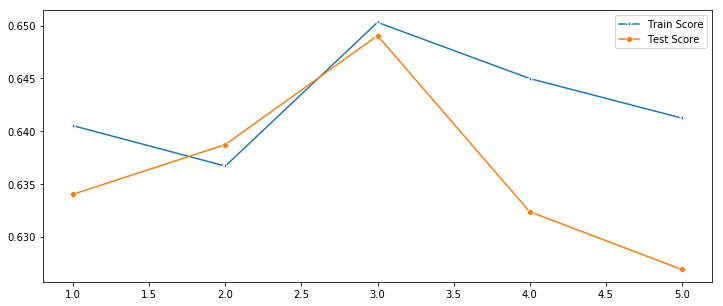

In [41]:
# result visualization with cross validation
plt.figure(figsize=(12,5))
p = sb.lineplot(range(1,6),nb_gb_train_scores,marker='*',label='Train Score')
p = sb.lineplot(range(1,6),nb_gb_test_scores,marker='o',label='Test Score')

In [47]:
# gaussian naive bayes without cross validation
nb_gb = GaussianNB()
nb_gb.fit(features_train, labels_train)
predicted_labels = nb_gb.predict(features_test)
print("Accuracy : ",accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.6327110040437064
[1 2 3 4 5 6]


Text(0.5, 15.0, 'Actual values')

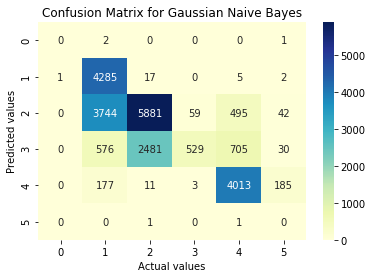

In [48]:
# confusion matrix
cnf_matrix = confusion_matrix(labels_test, predicted_labels)
p = sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title("Confusion Matrix for Gaussian Naive Bayes")
plt.ylabel("Predicted values")
plt.xlabel("Actual values")

In [45]:
# Bernoulli Naive Bayes Classifier using Cross validation
nb_b_test_scores = list()
nb_b_train_scores = list()
kfold = KFold(5, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(features_values):
    print("Train : ",train_index, "Validation : ", test_index)
    
    features_train_fold, labels_train_fold = features_values[train_index], labels_values[train_index]
    features_test_fold, labels_test_fold = features_values[test_index], labels_values[test_index]
    
    nb_b = BernoulliNB()
    nb_b.fit(features_train_fold, labels_train_fold)
    print("Test data score : ", nb_b.score(features_test_fold, labels_test_fold))
    nb_b_test_scores.append(nb_b.score(features_test_fold, labels_test_fold))
    print("Train data score : ", nb_b.score(features_train_fold, labels_train_fold))
    nb_b_train_scores.append(nb_b.score(features_train_fold, labels_train_fold))
    print("\n")
    
print(nb_b_test_scores)
print("Mean Accuracy : ", np.mean(nb_b_test_scores))
print("Max Accuracy : ", max(nb_b_test_scores))

Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    4     6    31 ... 54227 54228 54231]
Test data score :  0.9479166666666666
Train data score :  0.9549445737595353


Train :  [    2     3     4 ... 54236 54237 54238] Validation :  [    0     1     7 ... 54217 54225 54226]
Test data score :  0.9539085545722714
Train data score :  0.9534926597681547


Train :  [    0     1     2 ... 54234 54235 54236] Validation :  [    3     8    14 ... 54232 54237 54238]
Test data score :  0.952433628318584
Train data score :  0.9537461685603005


Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    5    15    18 ... 54233 54234 54235]
Test data score :  0.9457964601769911
Train data score :  0.9551519900440183


Train :  [    0     1     3 ... 54235 54237 54238] Validation :  [    2     9    10 ... 54220 54224 54236]
Test data score :  0.9504010325435605
Train data score :  0.9539546460176991


[0.9479166666666666, 0.9539085545722714, 0.952433628318584, 0.945796460

In [46]:
# Bernoulli Naive bayes without cross validation
nb_b = BernoulliNB()
nb_b.fit(features_train, labels_train)
predicted_labels = nb_b.predict(features_test)
print("Accuracy : ",accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.9496257420631506
[2 3 4 5]


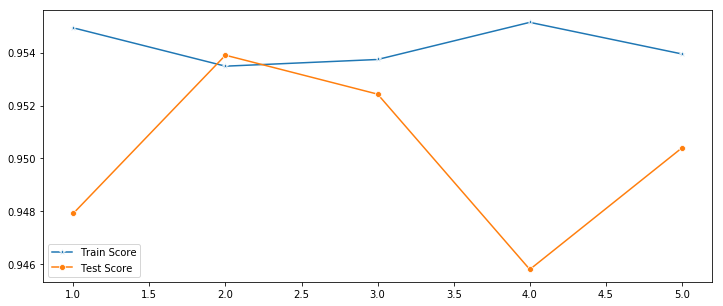

In [47]:
# result visualization with cross validation
plt.figure(figsize=(12,5))
p = sb.lineplot(range(1,6),nb_b_train_scores,marker='*',label='Train Score')
p = sb.lineplot(range(1,6),nb_b_test_scores,marker='o',label='Test Score')

Text(0.5, 15.0, 'Actual values')

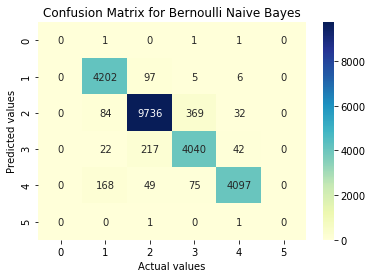

In [48]:
# confusion matrix
cnf_matrix = confusion_matrix(labels_test, predicted_labels)
p = sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title("Confusion Matrix for Bernoulli Naive Bayes")
plt.ylabel("Predicted values")
plt.xlabel("Actual values")

#### Decision Tree Classifier 

In [50]:
# Decision Tree Classifier | C5.0 with cross validation

dt_c_test_scores = list()
dt_c_train_scores = list()
kfold = KFold(5, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(features_values):
    print("Train : ",train_index, "Validation : ", test_index)
    
    features_train_fold, labels_train_fold = features_values[train_index], labels_values[train_index]
    features_test_fold, labels_test_fold = features_values[test_index], labels_values[test_index]
    
    dt_c = DecisionTreeClassifier(random_state=1,criterion="entropy")
    dt_c.fit(features_train_fold, labels_train_fold)
    print("Test data score : ", dt_c.score(features_test_fold, labels_test_fold))
    dt_c_test_scores.append(dt_c.score(features_test_fold, labels_test_fold))
    print("Train data score : ", dt_c.score(features_train_fold, labels_train_fold))
    dt_c_train_scores.append(dt_c.score(features_train_fold, labels_train_fold))
    print("\n")
    
print(dt_c_test_scores)
print("Mean Accuracy : ", np.mean(dt_c_test_scores))
print("Max Accuracy : ", max(dt_c_test_scores))

Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    4     6    31 ... 54227 54228 54231]
Test data score :  0.9165744837758112
Train data score :  0.9963356456408011


Train :  [    2     3     4 ... 54236 54237 54238] Validation :  [    0     1     7 ... 54217 54225 54226]
Test data score :  0.9204461651917404
Train data score :  0.9959669055794981


Train :  [    0     1     2 ... 54234 54235 54236] Validation :  [    3     8    14 ... 54232 54237 54238]
Test data score :  0.9209992625368731
Train data score :  0.9962895531331382


Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    5    15    18 ... 54233 54234 54235]
Test data score :  0.9130715339233039
Train data score :  0.9964278306561268


Train :  [    0     1     3 ... 54235 54237 54238] Validation :  [    2     9    10 ... 54220 54224 54236]
Test data score :  0.916382409882917
Train data score :  0.9963587758112095


[0.9165744837758112, 0.9204461651917404, 0.9209992625368731, 0.91307153

In [51]:
# Decision Tree Classifier | C5.0 with out cross validation
dt_c = DecisionTreeClassifier(random_state=1, criterion="entropy")
dt_c.fit(features_train, labels_train)
predicted_labels = dt_c.predict(features_test)
print("Accuracy : ", accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.9183945625053773
[1 2 3 4 5 6]


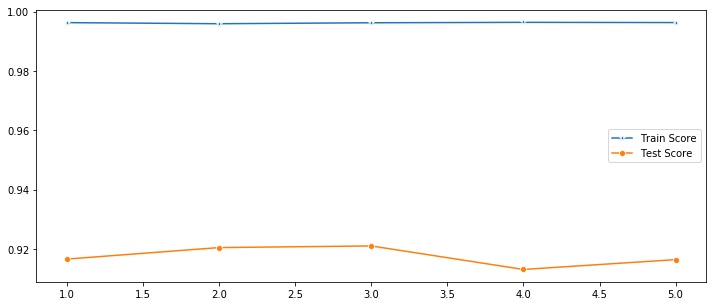

In [52]:
# result visualization with cross validation
plt.figure(figsize=(12,5))
p = sb.lineplot(range(1,6),dt_c_train_scores,marker='*',label='Train Score')
p = sb.lineplot(range(1,6),dt_c_test_scores,marker='o',label='Test Score')

Text(0.5, 15.0, 'Actual values')

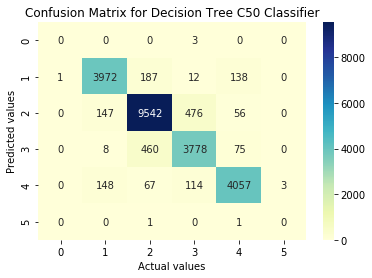

In [53]:
# Confusion Matrix
cnf_matrix = confusion_matrix(labels_test, predicted_labels)
p = sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title("Confusion Matrix for Decision Tree C50 Classifier")
plt.ylabel("Predicted values")
plt.xlabel("Actual values")

In [55]:
# Decision Tree Classifier | CART with cross validation

dt_ca_test_scores = list()
dt_ca_train_scores = list()
kfold = KFold(5, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(features_values):
    print("Train : ",train_index, "Validation : ", test_index)
    
    features_train_fold, labels_train_fold = features_values[train_index], labels_values[train_index]
    features_test_fold, labels_test_fold = features_values[test_index], labels_values[test_index]
    
    dt_ca = DecisionTreeClassifier(random_state=1,criterion="gini")
    dt_ca.fit(features_train_fold, labels_train_fold)
    print("Test data score : ", dt_ca.score(features_test_fold, labels_test_fold))
    dt_ca_test_scores.append(dt_ca.score(features_test_fold, labels_test_fold))
    print("Train data score : ", dt_ca.score(features_train_fold, labels_train_fold))
    dt_ca_train_scores.append(dt_ca.score(features_train_fold, labels_train_fold))
    print("\n")
    
print(dt_ca_test_scores)
print("Mean Accuracy : ", np.mean(dt_ca_test_scores))
print("Max Accuracy : ", max(dt_ca_test_scores))

Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    4     6    31 ... 54227 54228 54231]
Test data score :  0.917957227138643
Train data score :  0.9963356456408011


Train :  [    2     3     4 ... 54236 54237 54238] Validation :  [    0     1     7 ... 54217 54225 54226]
Test data score :  0.919339970501475
Train data score :  0.9959669055794981


Train :  [    0     1     2 ... 54234 54235 54236] Validation :  [    3     8    14 ... 54232 54237 54238]
Test data score :  0.9182337758112095
Train data score :  0.9962895531331382


Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    5    15    18 ... 54233 54234 54235]
Test data score :  0.913901179941003
Train data score :  0.9964278306561268


Train :  [    0     1     3 ... 54235 54237 54238] Validation :  [    2     9    10 ... 54220 54224 54236]
Test data score :  0.9131557112565687
Train data score :  0.9963587758112095


[0.917957227138643, 0.919339970501475, 0.9182337758112095, 0.913901179941

In [56]:
# Decision Tree Classifier | CART with out cross validation
dt_ca = DecisionTreeClassifier(random_state=1, criterion="gini")
dt_ca.fit(features_train, labels_train)
predicted_labels = dt_ca.predict(features_test)
print("Accuracy : ", accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.9179643809687689
[1 2 3 4 5 6]


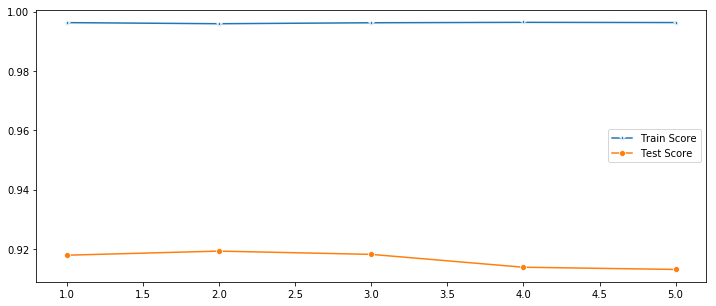

In [57]:
# result visualization with cross validation
plt.figure(figsize=(12,5))
p = sb.lineplot(range(1,6),dt_ca_train_scores,marker='*',label='Train Score')
p = sb.lineplot(range(1,6),dt_ca_test_scores,marker='o',label='Test Score')

Text(0.5, 15.0, 'Actual values')

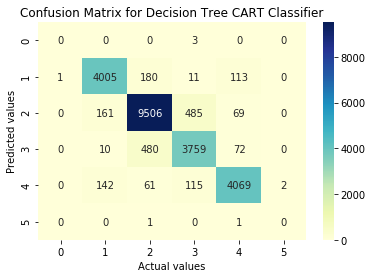

In [58]:
# Confusion Matrix
cnf_matrix = confusion_matrix(labels_test, predicted_labels)
p = sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title("Confusion Matrix for Decision Tree CART Classifier")
plt.ylabel("Predicted values")
plt.xlabel("Actual values")

#### Random Forest Classifier

In [59]:
# Random Forest Classifier with cross validation

rf_test_scores = list()
rf_train_scores = list()
kfold = KFold(5, shuffle=True, random_state=42)

for train_index, test_index in kfold.split(features_values):
    print("Train : ",train_index, "Validation : ", test_index)
    
    features_train_fold, labels_train_fold = features_values[train_index], labels_values[train_index]
    features_test_fold, labels_test_fold = features_values[test_index], labels_values[test_index]
    
    rf = RandomForestClassifier()
    rf.fit(features_train_fold, labels_train_fold)
    print("Test data score : ", rf.score(features_test_fold, labels_test_fold))
    rf_test_scores.append(rf.score(features_test_fold, labels_test_fold))
    print("Train data score : ", rf.score(features_train_fold, labels_train_fold))
    rf_train_scores.append(rf.score(features_train_fold, labels_train_fold))
    print("\n")
    
print(rf_test_scores)
print("Mean Accuracy : ", np.mean(rf_test_scores))
print("Max Accuracy : ", max(rf_test_scores))

Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    4     6    31 ... 54227 54228 54231]


/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test data score :  0.9369469026548672
Train data score :  0.9900901108524809


Train :  [    2     3     4 ... 54236 54237 54238] Validation :  [    0     1     7 ... 54217 54225 54226]


/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test data score :  0.9401733038348082
Train data score :  0.9903436196446268


Train :  [    0     1     2 ... 54234 54235 54236] Validation :  [    3     8    14 ... 54232 54237 54238]


/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test data score :  0.9385140117994101
Train data score :  0.990620174690604


Train :  [    0     1     2 ... 54236 54237 54238] Validation :  [    5    15    18 ... 54233 54234 54235]


/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test data score :  0.9336283185840708
Train data score :  0.9902744808831324


Train :  [    0     1     3 ... 54235 54237 54238] Validation :  [    2     9    10 ... 54220 54224 54236]


/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test data score :  0.9394302572139762
Train data score :  0.9905973451327433


[0.9369469026548672, 0.9401733038348082, 0.9385140117994101, 0.9336283185840708, 0.9394302572139762]
Mean Accuracy :  0.9377385588174265
Max Accuracy :  0.9401733038348082


In [60]:
# Random Forest Classifier without Cross Validation
rf_model = RandomForestClassifier()
rf_model.fit(features_train, labels_train)
predicted_labels = rf_model.predict(features_test)
print("Accuracy : ", accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

/home/scrap/anaconda3/envs/new_project/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy :  0.9367202959648971
[2 3 4 5]


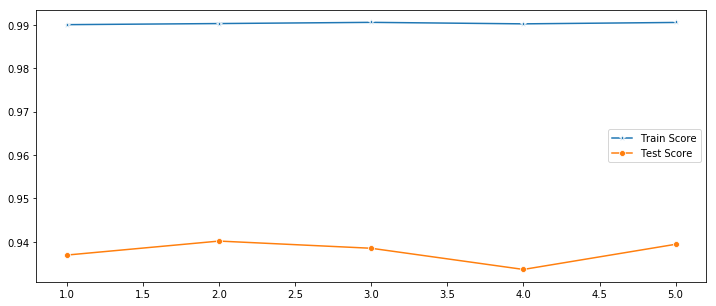

In [61]:
# result visualization with cross validation
plt.figure(figsize=(12,5))
p = sb.lineplot(range(1,6),rf_train_scores,marker='*',label='Train Score')
p = sb.lineplot(range(1,6),rf_test_scores,marker='o',label='Test Score')

Text(0.5, 15.0, 'Actual values')

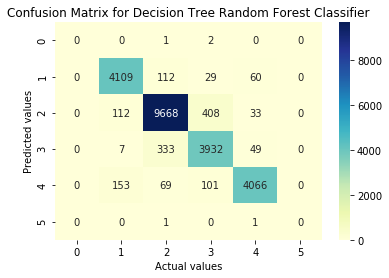

In [62]:
# Confusion Matrix
cnf_matrix = confusion_matrix(labels_test, predicted_labels)
p = sb.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title("Confusion Matrix for Decision Tree Random Forest Classifier")
plt.ylabel("Predicted values")
plt.xlabel("Actual values")

#### Gradient Boost Classifier 

In [66]:
# Gradient Boost Classifer without cross validation
gbm = GradientBoostingClassifier(criterion='mse',learning_rate=0.3,n_estimators=50)
gbm.fit(features_train,labels_train)
predicted_labels = gbm.predict(features_test)
print("Accuracy : ",accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.9426568011700938
[1 2 3 4 5 6]


#### KNN Classifier

In [71]:
# K Nearest Neighbour without cross validation
knn = KNeighborsClassifier()
knn.fit(features_train, labels_train)
predicted_labels = knn.predict(features_test)
print("Accuracy : ", accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.8249591327540222
[2 3 4 5]


#### Xtreme Gradient Boost Classifier 

In [42]:
# Xtreme Gradient boost Classifier
xgb = XGBClassifier(max_depth = 3, learning_rate=0.3, n_jobs=4, n_estimators=100)
xgb.fit(features_train, labels_train)
predicted_labels = xgb.predict(features_test)
print("Accuracy : ", accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.9463133442312656
[2 3 4 5]


### Modelling and Evaluation

In [43]:
# Accuracies with different Algorithms : 
# Xtreme Gradient Boost Classifier : 0.9463133 | [2 3 4 5]
# K Nearest Neighbour : 0.8249591 | [2 3 4 5]
# Gradient Boost Classifier : 0.9426568011700938 | [1 2 3 4 5 6]
# Random Forest Classifier : 0.9367202959648971 | [2 3 4 5]
# Decision Tree, CART : 0.9179643809687689 | [1 2 3 4 5 6]
# Decision Tree, C50 : 0.9183945625053773 | [1 2 3 4 5 6]
# Bernoulli Naive Bayes : 0.9496257420631506 | [2 3 4 5]
# Gaussian naive Bayes : 0.6327110040437064 | [1 2 3 4 5 6]

In [44]:
# Further processing with the Gradeint Boost Algorithm as it gives the best results 
# and optimizing it using KFold cross validation

In [47]:
# Gradient Boost Classifier with optimization and cross validation
gbm_train_scores = list()
gbm_test_scores = list()

kfold = KFold(5, shuffle = True, random_state=42)

for train_index, test_index in kfold.split(features_values):
    features_train_fold, labels_train_fold = features_train[train_index], labels_train[train_index]
    features_test_fold, labels_test_fold = features_test[test_index], features_test[test_index]
    
    gbm = GradientBoostingClassifier(criterion="mse", learning_rate=0.1, n_estimators=200, subsample=0.4,)
    gbm.fit(features_train_fold, labels_train_fold)
    print("Test Data Score : ", gbm.score(features_test_fold, labels_test_fold))
    gbm_test_scores.append(gbm.score(features_test_fold, labels_test_fold))
    print("Train Data Score : ", gbm.score(features_train_fold, labels_train_fold))
    gbm_train_scores.append(gbm.score(features_train_fold, labels_train_fold))
    print("\n")

print(gbm_test_scores)
print("Mean Accuracy : ", np.mean(gbm_test_scores))
print("Maximum Accuracy : ", max(gbm_test_scores))

'\ngbm_train_scores = list()\ngbm_test_scores = list()\n\nkfold = KFold(5, shuffle = True, random_state=42)\n\nfor train_index, test_index in kfold.split(features_values):\n    features_train_fold, labels_train_fold = features_train[train_index], labels_train[train_index]\n    features_test_fold, labels_test_fold = features_test[test_index], features_test[test_index]\n    \n    gbm = GradientBoostingClassifier(criterion="mse", learning_rate=0.1, n_estimators=200, subsample=0.4,)\n    gbm.fit(features_train_fold, labels_train_fold)\n    print("Test Data Score : ", gbm.score(features_test_fold, labels_test_fold))\n    gbm_test_scores.append(gbm.score(features_test_fold, labels_test_fold))\n    print("Train Data Score : ", gbm.score(features_train_fold, labels_train_fold))\n    gbm_train_scores.append(gbm.score(features_train_fold, labels_train_fold))\n    print("\n")\n\nprint(gbm_test_scores)\nprint("Mean Accuracy : ", np.mean(gbm_test_scores))\nprint("Maximum Accuracy : ", max(gbm_test_

In [70]:
# Gradient boost Classifier with optimization
gbm = GradientBoostingClassifier(criterion="mse", learning_rate=0.1, n_estimators=200, subsample=0.4)
gbm.fit(features_train, labels_train)
predicted_labels = gbm.predict(features_test)
print("Accuracy : ", accuracy_score(labels_test, predicted_labels))
print(np.unique(predicted_labels))

Accuracy :  0.9463470319634704
[1 2 3 4 5 6]


In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(labels_test, predicted_labels))

In [ ]:
# confusion matrix
cnf_matrix = confusion_matrix(labels_test, predicted_labels)
sb.heatmap(cnf_matrix, annot = True, fmt = "d", cmap="YlGnBu")

In [50]:
type(predicted_labels)

In [51]:
predictions = pd.DataFrame(predicted_labels)
predictions.head(2)

In [52]:
resultant_df = pd.concat([records, predictions], sort = False, axis = 1)
resultant_df.head(5)
columns = ["recordsId","actual","predicted"]
resultant_df.columns = columns
resultant_df.head(5)

In [ ]:
resultant_df.to_csv("predictions.csv", index = False, encoding = "utf-8")
resultant_df.shape

## Database and results

In [ ]:
import csv
from mysql.connector import connection

In [ ]:
# connecting to mysql server
db_name = "test"
cnx = connection.MySQLConnection(user = "root", password = "12345", host = "localhost")
cursor = cnx.cursor()

# creating database
try:
    cursor.execute("create database if not exists {}".format(db_name))
    print("Sucessfully created database".center(110,"-"))
except Exception as e:
    print(e)

table_name = "prediction"
# create table 
try:
    cursor.execute("use {}".format(db_name))
    cursor.execute("create table if not exists {} (recordID int(8) not null, actual_value int(2) not null, predict_value int(2) not null)".format(table_name))
    print("Successfully created table".center(110,"-"))
except Exception as e:
    print(e)

In [ ]:
cursor.execute("truncate table {}".format(table_name))
print("truncated table {}".format(table_name))
cnx.commit()

In [ ]:
with open("predictions.csv","r") as csv_file:
    reader = csv.DictReader(csv_file, delimiter = ",")
    for row in reader:
        #print(row["predicted"],row["recordsId"],row["actual"])
        cursor.execute("insert into prediction values (%s,%s,%s)",(row["recordsId"],row["actual"],row["predicted"]))
cnx.commit()
print("records updated")

In [ ]:
# results for priority 1
try:
    cursor.execute("select recordID from prediction where predict_value = 1")
    for d in cursor:
        print(d)
except Exception as e:
    print(e)

In [ ]:
# results for priority 2
try:
    cursor.execute("select recordID from prediction where predict_value = 2")
    for d in cursor:
        print(d)
except Exception as e:
    print(e)

In [ ]:
# results for priority 3
try:
    cursor.execute("select recordID from prediction where predict_value = 3")
    for d in cursor:
        print(d)
except Exception as e:
    print(e)

In [ ]:
# results for priority 4
try:
    cursor.execute("select recordID from prediction where predict_value = 4")
    for d in cursor:
        print(d)
except Exception as e:
    print(e)

In [ ]:
# results for priority 5
try:
    cursor.execute("select recordID from prediction where predict_value = 5")
    for d in cursor:
        print(d)
except Exception as e:
    print(e)

In [ ]:
# results for priority 6
try:
    cursor.execute("select recordID from prediction where predict_value = 6")
    for d in cursor:
        print(d)
except Exception as e:
    print(e)

In [ ]:
cursor.close()